In [1]:
import pandas as pd
import numpy as np
import json  
import zipfile
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
import string
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
from textblob import TextBlob
from textblob import Word
import random
from sklearn.svm import SVC
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report
import collections
from collections import Counter
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import make_pipeline
from sklearn.svm import SVC

In [2]:
wikidata = pd.read_json('wikidata-movies.json.gz', orient='record', lines=True)
genres = pd.read_json('genres.json.gz', orient='record', lines=True)
rotten = pd.read_json('rotten-tomatoes.json.gz', orient='record', lines=True)
omdb = pd.read_json('omdb-data.json.gz', orient='record', lines=True)
movies_token=pd.read_csv('tokenized_data.csv')
# omdb has the ====== imdb_id  and the plot is also there in it 
# rotten has the imdb_id and rotten_tomato_id along with all the ratings
# genres has the wikidata_id
# wikidata has the imdb_id, wiki_id and the rotten_tomato_id

In [18]:
tokens=omdb['omdb_plot']

In [19]:
def text_process(mess):
    """
    Takes in a string of text, then performs the following:
    1. Remove all punctuation
    2. Remove all stopwords
    3. Returns cleaned text
    """
    # Check characters to see if they are in punctuation
    nopunc = [char for char in mess if char not in string.punctuation]

    # Join the characters again to form the string.
    nopunc = ''.join(nopunc)
    
    # Now just remove any stopwords
    nonstop=[word for word in nopunc.split() if word.lower() not in stopwords.words('english')]
    
    return  ' '.join(nonstop)

In [20]:
tokens=tokens.apply(text_process)

In [21]:
omdb['tokenized']=tokens

In [22]:
omdb['polarity_full_string'] = omdb.omdb_plot.apply(lambda x: TextBlob(x).sentiment.polarity)

omdb

In [23]:
#omdb['tokenized']=movies_token['tokenized']

In [24]:
 
def give_sentiment(x):
    if((x >= 0.5) and (x < 0.8)):
        return 'positive'
    elif(x >=0.8):
        return 'Really positive'
    elif((x >= 0) and (x <0.5)):
        return 'fine'
    elif((x<0) and (x>= -0.5)):
        return 'bit negative'
    elif((x<-0.5) and (x>= -1)):
        return 'negative'

In [25]:
omdb['movie_nature'] = (omdb.polarity_full_string.apply(lambda x: give_sentiment(x)))

In [26]:
movies = rotten.merge(omdb, how='inner', on='imdb_id')

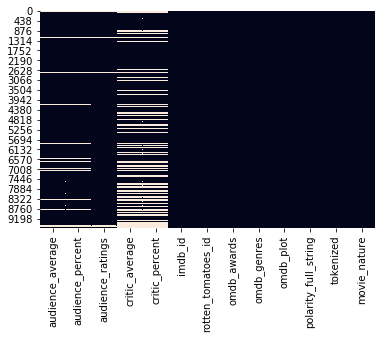

In [27]:
sns.heatmap(movies.isnull(), cbar=False)

In [28]:
movies = movies.dropna(subset=['audience_average','critic_average'])
movies = movies[movies['omdb_awards'] != 'N/A']

In [29]:
# machince learning model 2 using natural-language-processing



bow_transformer = CountVectorizer(analyzer=text_process).fit(omdb.tokenized)
#lets use.transform on our Bag-of-Words (bow) transformed object and transform the entire DataFrame of messages
plot_bow = bow_transformer.transform(omdb.tokenized)
print('Shape of Sparse Matrix: ', plot_bow.shape)
print('Amount of Non-Zero occurences: ', plot_bow.nnz)
# since, the counting is done now the term weighting and normalization can be done with TF-IDF
tfidf_transformer = TfidfTransformer().fit(plot_bow)
#To transform the entire bag-of-words corpus into TF-IDF
plot_tfidf = tfidf_transformer.transform(plot_bow)



Shape of Sparse Matrix:  (9676, 105)
Amount of Non-Zero occurences:  292838


In [30]:
plot_train, plot_test, nature_train, nature_test =train_test_split(movies.tokenized, movies.movie_nature, test_size=0.5)
pipeline = Pipeline([
    ('bow', CountVectorizer(analyzer=text_process)),  # strings to token integer counts
    ('tfidf', TfidfTransformer()),  # integer counts to weighted TF-IDF scores
    ('classifier', SVC(kernel='rbf')),  # train on TF-IDF vectors 
])
pipeline.fit(plot_train,nature_train)

/Users/ronitchawla/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Pipeline(memory=None,
     steps=[('bow', CountVectorizer(analyzer=<function text_process at 0x1a33090158>,
        binary=False, decode_error='strict', dtype=<class 'numpy.int64'>,
        encoding='utf-8', input='content', lowercase=True, max_df=1.0,
        max_features=None, min_df=1, ngram_range=(1, 1), preprocessor=None...f', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False))])

In [31]:
print(pipeline.score(plot_train, nature_train))
print(pipeline.score(plot_test, nature_test))

0.6738975817923186
0.6657183499288762
